In [1]:
import os 
from ipsl_dataset import IPSL_DCPP
import torch
import numpy as np
import hydra
from ipsl_dataset import surface_variables,plev_variables
from hydra import compose, initialize
from omegaconf import OmegaConf
with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config",overrides=["experiment=one_month_single_variable_v100"])
import matplotlib.pyplot as plt
checkpoint_path = '1u1m7ygx/checkpoints/checkpoint_epoch=00.ckpt'


In [2]:
import datetime
def inc_time(batch_time):
    batch_time = datetime.datetime.strptime(batch_time,'%Y-%m')
    if(batch_time.month == 12):
        year = batch_time.year + 1
        month = 1
    else:
        year = batch_time.year
        month = batch_time.month + 1
    return f'{year}-{month}'
    

In [3]:
def rollout(length,dataloader):
    iter_dl = iter(dataloader)
    surfaces = []
    plevs = []
    model_plevs = []
    model_surfaces = []
    for i in range(length):
        batch_actual = next(iter_dl)
        if(i == 0):
            batch = batch_actual
        model_surfaces.append(batch_actual['next_state_surface'])
        #model_plevs.append(batch_actual['next_state_level'])
        print(batch['time'])

       # print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)
        with torch.no_grad():
            output = soil_model.forward(batch)

       # output['next_state_surface'][:,var_index] = torch.where(land_mask == 1,output['next_state_surface'][:,var_index],0)
        batch=dict(state_surface=output['next_state_surface'],
                   #state_level=output['next_state_level'] + batch['state_level'], 
                   state_depth=output['next_state_depth'],
                   state_constant=batch['state_constant'],
                   next_state_surface=output['next_state_surface'],
                   next_state_depth=output['next_state_depth'],
                  time=[inc_time(batch['time'][0])])
        surfaces.append(batch['state_surface'])
    #    plevs.append(output['next_state_level'])
    return surfaces,model_surfaces,batch,batch_actual

In [5]:
work = os.environ['WORK']

checkpoint = torch.load( f'{work}/ipsl_dcpp/ipsl_dcpp_emulation/{checkpoint_path}',map_location=torch.device('cpu'))
test = IPSL_DCPP('test',lead_time_months=1,surface_variables=cfg.experiment.surface_variables,depth_variables=cfg.experiment.depth_variables)
test_dataloader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False)

soil_model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(
        cfg.experiment.backbone,
        patch_size=eval(cfg.experiment.patch_size)
    ),
    dataset=test_dataloader.dataset
)
soil_model.load_state_dict(checkpoint['state_dict'])

surface_var_name = 'gpp'
#plev_var_name = 'hur'
var_index = surface_variables.index(surface_var_name)

/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ConfigAttributeError: Key 'patch_size' is not in struct
    full_key: experiment.patch_size
    object_type=dict

In [29]:
pred_rollout,batch_rollout,pred,batch = rollout(1,test_dataloader)

['2013-01']


In [30]:
pred_denorm,batch_denorm = soil_model.dataset.denormalize(pred, batch)

In [32]:

#plev_var_index = plev_variables.index(plev_var_name)
#ts = np.stack(pred_rollout).squeeze()[:,var_index].mean(axis=(1,2))
#ts = np.stack(pred_rollout).squeeze()[var_index].mean(axis=(-2,-1))

#plev_ts = np.stack(plevs).squeeze()[:,plev_var_index].mean(axis=(2,3))
gpp_data = pred_denorm['next_state_surface'].squeeze()
gpp_model_data = batch_denorm['next_state_surface'].squeeze()

In [33]:
pred_rollout

[tensor([[[[-0.0190, -0.0306, -0.0473,  ...,  0.0171, -0.1244, -0.0538],
           [-0.0884, -0.0938,  0.0080,  ...,  0.0063, -0.0022,  0.0282],
           [-0.0765, -0.0217, -0.1445,  ...,  0.0846,  0.0424,  0.0370],
           ...,
           [ 0.0253,  0.0454,  0.1190,  ...,  0.1094,  0.0425, -0.0388],
           [ 0.1257,  0.1140,  0.0793,  ...,  0.0593,  0.0209, -0.0778],
           [ 0.0685,  0.0221,  0.1094,  ...,  0.0170, -0.0047, -0.0527]]]])]

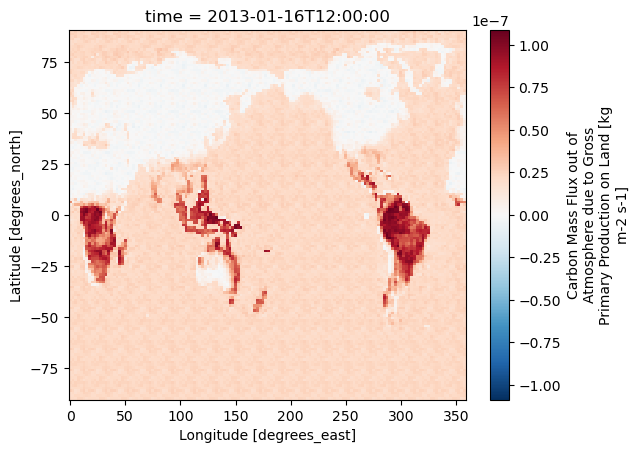

In [34]:
import xarray as xr
ds = xr.open_dataset(test.files[0])
shell = ds.isel(time=0)

shell['gpp'].data = gpp_data
shell['gpp'].plot.pcolormesh()

In [ ]:
#np.save('surface_rollout.npy',surfaces)
#np.save('plevel_rollout.npy',plevs)

In [ ]:
gpp_model_data = np.stack(model_surfaces).squeeze()[:,var_index]

In [ ]:
#plev_model = np.stack(model_plevs).squeeze()[:,plev_var_index].mean(axis=(2,3))
ts_model = np.stack(model_surfaces).squeeze()[:,var_index].mean(axis=(1,2))

Text(0.5, 1.0, 'gpp')

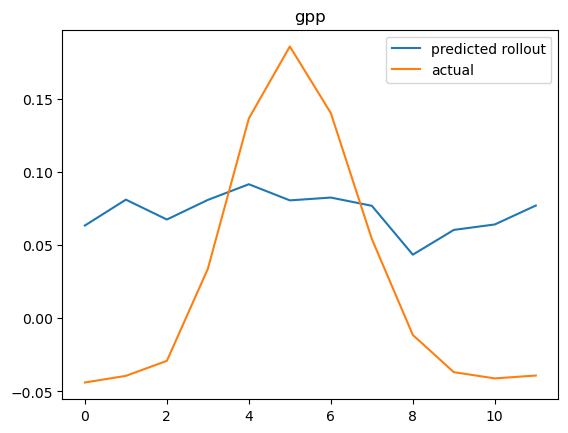

In [11]:
#plot surface variables
plt.plot(ts,label='predicted rollout')
plt.plot(ts_model,label='actual')
plt.legend()
plt.title(surface_var_name)
#print pressure levels
#plt.plot(plev_ts[:,-3],label='predicted rollout')
#plt.plot(plev_model[:,-3],label='actual')
#plt.legend()
#plt.title(plev_var_name)

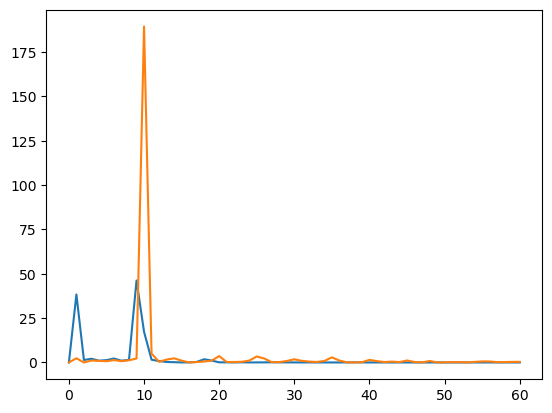

In [11]:
#get data for power series
stacked_pred_surfaces = np.stack(surfaces)
stacked_model_surfaces = np.stack(model_surfaces)
pred_timeseries = stacked_pred_surfaces[:,:,var_index,100,100]
model_timeseries = stacked_model_surfaces[:,:,var_index,100,100]
#plot power series
import scipy
pred_power = scipy.signal.periodogram(pred_timeseries.T)
model_power = scipy.signal.periodogram(model_timeseries.T)
import matplotlib.pyplot as plt
plt.plot(pred_power[-1][0])
plt.plot(model_power[-1][0])

In [4]:
surface_var_name = 'gpp'
plev_var_name = 'hurs'
var_index = surface_variables.index(surface_var_name)
# predicted = np.stack(surfaces).squeeze()[:,var_index]
# climate_model = np.stack(model_surfaces).squeeze()[:,var_index]

In [ ]:
#gif of rollout
# Plotting ---
import matplotlib.pyplot as plt
#import seaborn
from celluloid import Camera

# seaborn.set_context("paper")
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))
camera = Camera(fig)
ax1.set_title("predicted")
ax2.set_title("IPSL_CM6A")
import xarray as xr
ds = xr.open_dataset(test.files[0])
shell = ds.isel(time=0)

# Animate plot over time
for time_step in range(118):
    #ax1.plot(predicted[time_step])
    shell[surface_var_name].data = predicted[time_step]
    shell[surface_var_name].plot.pcolormesh(ax=ax1,add_colorbar=False)
    shell[surface_var_name].data = climate_model[time_step]

    shell[surface_var_name].plot.pcolormesh(ax=ax2,add_colorbar=False)
    #ax2.plot(climate_model[time_step])
    camera.snap()
anim = camera.animate()
anim.save(f"{surface_var_name}_{checkpoint_folder}_rollout.gif")

In [5]:
#get avg of all test data of gpp flow 
iter_ts = iter(test_dataloader)


In [6]:

def get_decadal_ts_avgs(iter_ts):
    gpp_avgs = [[] for x in range(0,118)]
    count = 0
    run_count = 0
    while run_count < 10:
        data = next(iter_ts,None)
        print(data['time'],count)
        if(data == None):
            return gpp_avgs
        gpp_avgs[count % 117].append(data['state_surface'].squeeze()[var_index])
        if(count % 117 == 0 and count > 100):
            print('end ',count)
            count = 0
            run_count = run_count + 1

        else:
            count = count + 1
    return gpp_avgs

In [ ]:
gpp_avgs = get_decadal_ts_avgs(iter_ts)

['2014-01'] 0
['2014-02'] 1
['2014-03'] 2
['2014-04'] 3
['2014-05'] 4
['2014-06'] 5
['2014-07'] 6
['2014-08'] 7
['2014-09'] 8
['2014-10'] 9
['2014-11'] 10
['2014-12'] 11
['2015-01'] 12
['2015-02'] 13
['2015-03'] 14
['2015-04'] 15
['2015-05'] 16
['2015-06'] 17
['2015-07'] 18
['2015-08'] 19
['2015-09'] 20
['2015-10'] 21
['2015-11'] 22
['2015-12'] 23
['2016-01'] 24
['2016-02'] 25
['2016-03'] 26
['2016-04'] 27
['2016-05'] 28
['2016-06'] 29
['2016-07'] 30
['2016-08'] 31
['2016-09'] 32
['2016-10'] 33
['2016-11'] 34
['2016-12'] 35
['2017-01'] 36
['2017-02'] 37
['2017-03'] 38
['2017-04'] 39
['2017-05'] 40
['2017-06'] 41
['2017-07'] 42
['2017-08'] 43
['2017-09'] 44
['2017-10'] 45
['2017-11'] 46
['2017-12'] 47
['2018-01'] 48
['2018-02'] 49
['2018-03'] 50
['2018-04'] 51
['2018-05'] 52
['2018-06'] 53
['2018-07'] 54
['2018-08'] 55
['2018-09'] 56
['2018-10'] 57
['2018-11'] 58
['2018-12'] 59
['2019-01'] 60
['2019-02'] 61
['2019-03'] 62
['2019-04'] 63
['2019-05'] 64
['2019-06'] 65
['2019-07'] 66
['201

In [8]:
final_averages = []
for month in range(0,12):
    final_averages.append(np.stack(gpp_avgs[month]).mean((0,1)))

In [9]:
np.save('gpp_averages',np.stack(final_averages))

In [2]:
import numpy as np
gpp_averages = np.load('gpp_averages.npy')

In [4]:
gpp_averages.shape

(12, 144)

In [ ]:


#gif of gpp averaged from 10 runs of test
from celluloid import Camera

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))
camera = Camera(fig)
ax1.set_title("predicted")
ax2.set_title("IPSL_CM6A")
import xarray as xr
ds = xr.open_dataset(test.files[0])
shell = ds.isel(time=0)

# Animate plot over time
for time_step in range(118):
    #ax1.plot(predicted[time_step])
    shell[surface_var_name].data = predicted[time_step]
    shell[surface_var_name].plot.pcolormesh(ax=ax1,add_colorbar=False)
    shell[surface_var_name].data = climate_model[time_step]

    shell[surface_var_name].plot.pcolormesh(ax=ax2,add_colorbar=False)
    #ax2.plot(climate_model[time_step])
    camera.snap()
anim = camera.animate()
anim.save(f"gpp_avg_rollout.gif")

In [1]:
from ipsl_dataset import surface_variables

# len(surface_variables)

91